In [60]:
import pandas as pd
import requests
import random
import string
import base64
import hashlib
import webbrowser
from urllib.parse import urlencode

def generate_code_verifier(length: int) -> str:
    possible = string.ascii_letters + string.digits
    return ''.join(random.choice(possible) for _ in range(length))

def generate_code_challenge(code_verifier: str) -> str:
    # create SHA-256 hash of verifier
    data = code_verifier.encode('utf-8')
    digest = hashlib.sha256(data).digest()
    
    # base64url encode the hash
    b64 = base64.b64encode(digest).decode('utf-8')
    return b64.replace('+', '-').replace('/', '_').replace('=', '')

async def redirect_to_auth_code_flow(client_id: str) -> str:
    verifier = generate_code_verifier(128)
    challenge = generate_code_challenge(verifier)
    
    params = {
        "client_id": client_id,
        "response_type": "code",
        "redirect_uri": "https://localhost:3000",
        "scope": "user-read-private user-read-email user-top-read",  # Added user-top-read
        "code_challenge_method": "S256",
        "code_challenge": challenge
    }
    
    auth_url = f"https://accounts.spotify.com/authorize?{urlencode(params)}"
    webbrowser.open(auth_url)
    
    return verifier

import requests
from urllib.parse import urlencode

async def get_access_token(client_id: str, code: str, verifier: str) -> str:
    url = "https://accounts.spotify.com/api/token"
    
    params = {
        "client_id": client_id,
        "grant_type": "authorization_code",
        "code": code,
        "redirect_uri": "https://localhost:3000",
        "code_verifier": verifier
    }
    
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    
    response = requests.post(url, headers=headers, data=params)
    
    if response.status_code == 200:
        return response.json()["access_token"]
    else:
        raise Exception(f"Failed to get access token: {response.status_code} - {response.text}")
    
import requests

async def get_profile(token: str) -> dict:
    url = "https://api.spotify.com/v1/me"
    headers = {
        "Authorization": f"Bearer {token}"
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to get profile: {response.status_code} - {response.text}")
    
async def get_top_tracks(token: str, limit: int = 5, time_range: str = "short_term", offset: int = 0) -> dict:
    url = "https://api.spotify.com/v1/me/top/tracks"
    headers = {
        "Authorization": f"Bearer {token}"
    }
    params = {
        "limit": limit,
        "time_range": time_range,
        "offset": offset
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to get top tracks: {response.status_code} - {response.text}")
    
async def get_track_data(token: str, track_name: str, artist_name: str) -> dict:
    # first, search for the track
    url = 'https://api.spotify.com/v1/search'
    headers = {
        'Authorization': f'Bearer {token}'
    }
    params = {
        'q': f'track:{track_name} artist:{artist_name}',
        'type': 'track',
        'limit': 1
    }
    
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        raise Exception(f"Search failed: {response.status_code} - {response.text}")
    
    search_results = response.json()
    if not search_results['tracks']['items']:
        print(f"No results found for {track_name} by {artist_name}")
        return None
    
    track = search_results['tracks']['items'][0]
    
    # get audio features for the track
    audio_features_url = f"https://api.spotify.com/v1/audio-features/{track['id']}"
    features_response = requests.get(audio_features_url, headers=headers)
    if features_response.status_code == 200:
        audio_features = features_response.json()
    else:
        audio_features = None
        print(f"Could not get audio features for {track_name}")
    
    # combine track data with audio features
    track_data = {
        'name': track['name'],
        'artists': ', '.join(artist['name'] for artist in track['artists']),
        'album': track['album']['name'],
        'release_date': track['album']['release_date'],
        'popularity': track['popularity'],
        'duration_ms': track['duration_ms'],
        'explicit': track['explicit'],
        'preview_url': track['preview_url'],
        'external_url': track['external_urls']['spotify'],
        'track_id': track['id']
    }
    
    # if available we add the audio features
    if audio_features:
        features_to_include = [
            'danceability', 'energy', 'key', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'time_signature'
        ]
        for feature in features_to_include:
            track_data[feature] = audio_features[feature]
    
    return track_data

async def get_spotify_playlist(token: str, id: str) -> dict:
    url = f"https://api.spotify.com/v1/playlists/{id}" # the id corresponds to different playlists, you can find them in the link Spotify provides when sharing playlists
    headers = {
        "Authorization": f"Bearer {token}"
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to get global tracks: {response.status_code} - {response.text}")



In [61]:
import os
from urllib.parse import urlencode

CLIENT_ID = os.environ.get('SPOTIFY_CLIENT_ID')

if not CLIENT_ID:
    raise ValueError("Please set SPOTIFY_CLIENT_ID environment variable")

async def main():
    verifier = await redirect_to_auth_code_flow(CLIENT_ID)
    print("\nAfter authorizing in your browser, copy the 'code' parameter from the URL")
    print("The URL will look like: https://localhost:3000?code=SOMETHING, where https://localhost:3000 will be the url you entered as the Spotify redirect uri when you created the Spotify app on the developer website")
    
    auth_code = input("Enter the code from the URL: ")
    
    access_token = await get_access_token(CLIENT_ID, auth_code, verifier)
    print("Successfully got access token!")
    
    # get my personal top 100 tracks
    top_tracks = []

    for i in range(5):
        items = await get_top_tracks(access_token, limit=20, offset=i*20)
        top_tracks.extend(items['items'])

    print("\nYour Top 100 Tracks:")
    print("-----------------")
    for i, track in enumerate(top_tracks, 1):
        artists = ", ".join(artist['name'] for artist in track['artists'])
    
    # get my personal track data
    track_data = []
    for track in top_tracks:
        track_data.append(await get_track_data(access_token, track['name'], track['artists'][0]['name']))

    # get global top 50 tracks
    global_playlist = await get_spotify_playlist(access_token, '37i9dQZEVXbMDoHDwVN2tF') # global top 50 playlist id
    global_tracks = global_playlist['tracks']['items']
    
    print("\nGlobal Top 50 Tracks:")
    print("-----------------")
    for i, item in enumerate(global_tracks, 1):
        track = item['track']
        artists = ", ".join(artist['name'] for artist in track['artists'])
        print(f"{i}. {track['name']} by {artists}")
    
    # get track data for global tracks
    global_track_data = []
    for item in global_tracks:
        track = item['track']
        global_track_data.append(await get_track_data(access_token, track['name'], track['artists'][0]['name']))

    # get usa top 50 tracks
    usa_playlist = await get_spotify_playlist(access_token, '37i9dQZEVXbLp5XoPON0wI') # usa top 50 playlist id
    usa_tracks = usa_playlist['tracks']['items']
    
    print("\nUSA Top 50 Tracks:")
    print("-----------------")
    for i, item in enumerate(usa_tracks, 1):
        track = item['track']
        artists = ", ".join(artist['name'] for artist in track['artists'])
    
    # get track data for usa tracks
    usa_track_data = []
    for item in usa_tracks:
        track = item['track']
        usa_track_data.append(await get_track_data(access_token, track['name'], track['artists'][0]['name']))

    # get new releases
    new_releases = await get_spotify_playlist(access_token, '37i9dQZF1DX4JAvHpjipBk') # new music friday playlist id
    new_releases_tracks = new_releases['tracks']['items']

    # get track data for new releases
    new_releases_track_data = []
    for item in new_releases_tracks:
        track = item['track']
        data = await get_track_data(access_token, track['name'], track['artists'][0]['name'])
        if data:
            new_releases_track_data.append(data)

    return track_data, global_track_data, usa_track_data, new_releases_track_data

In [62]:
my_track_data, global_track_data, usa_track_data, new_track_data = await main()


After authorizing in your browser, copy the 'code' parameter from the URL
The URL will look like: https://localhost:3000?code=SOMETHING, where https://localhost:3000 will be the url you entered as the Spotify redirect uri when you created the Spotify app on the developer website


Exception: Failed to get access token: 400 - {"error":"invalid_request","error_description":"code must be supplied"}

In [78]:
my_track_data_df = pd.DataFrame(my_track_data)
my_track_data_df.to_csv('my_top_100_tracks.csv', index=False)

global_track_data_df = pd.DataFrame(global_track_data)
global_track_data_df.to_csv('global_top_50_tracks.csv', index=False)

usa_track_data_df = pd.DataFrame(usa_track_data)
usa_track_data_df.to_csv('usa_top_50_tracks.csv', index=False)

new_track_data_df = pd.DataFrame(new_track_data)
new_track_data_df.to_csv('new_releases_tracks.csv', index=False)

[{'name': '+57', 'artists': 'KAROL G, Feid, DFZM, Ovy On The Drums, J Balvin, Maluma, Ryan Castro, Blessd', 'album': '+57', 'release_date': '2024-11-08', 'popularity': 69, 'duration_ms': 298130, 'explicit': True, 'preview_url': None, 'external_url': 'https://open.spotify.com/track/3mg9jYNC1NihbthlglzrWP', 'track_id': '3mg9jYNC1NihbthlglzrWP', 'danceability': 0.848, 'energy': 0.712, 'key': 1, 'loudness': -3.574, 'mode': 0, 'speechiness': 0.0981, 'acousticness': 0.221, 'instrumentalness': 0, 'liveness': 0.106, 'valence': 0.692, 'tempo': 91.98, 'time_signature': 4}, {'name': 'High Road', 'artists': 'Zach Bryan', 'album': 'High Road', 'release_date': '2024-11-07', 'popularity': 65, 'duration_ms': 199893, 'explicit': True, 'preview_url': 'https://p.scdn.co/mp3-preview/ed1ff5ddabcf919544dbb51ed234ad41dc1cc61f?cid=ba885e55a755485696432cb609741279', 'external_url': 'https://open.spotify.com/track/4CcozggmhXmndssEDH6YHR', 'track_id': '4CcozggmhXmndssEDH6YHR', 'danceability': 0.47, 'energy': 0.2

In [35]:
# if we've already got the data, just run this cell instead of the above ones
import pandas as pd

my_track_data_df = pd.read_csv('my_top_100_tracks.csv')
global_track_data_df = pd.read_csv('global_top_50_tracks.csv')
usa_track_data_df = pd.read_csv('usa_top_50_tracks.csv')
new_track_data_df = pd.read_csv('new_releases_tracks.csv')

combined_df = pd.concat([my_track_data_df, global_track_data_df, usa_track_data_df])
combined_df.to_csv('spotify_top_tracks.csv', index=False)

In [36]:
combined_df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,74.295000,204730.655000,0.606615,0.606552,5.035000,-6.922310,0.655000,0.103249,0.282535,0.024192,0.173640,0.439778,117.727775,3.840000
std,17.688198,54804.835037,0.163648,0.187423,3.870228,2.846009,0.476561,0.115680,0.283968,0.110291,0.121581,0.262098,29.333606,0.495609
min,20.000000,64840.000000,0.000000,0.020300,0.000000,-23.163000,0.000000,0.000000,0.000307,0.000000,0.039800,0.000000,0.000000,0.000000
25%,60.000000,169917.000000,0.496750,0.471750,1.000000,-8.248750,0.000000,0.034350,0.037350,0.000000,0.101000,0.212750,97.095000,4.000000
50%,81.000000,200901.000000,0.617000,0.639000,5.000000,-6.344000,1.000000,0.045400,0.180500,0.000002,0.123000,0.421000,114.896000,4.000000
75%,88.000000,240400.000000,0.730500,0.743500,9.000000,-4.976000,1.000000,0.115750,0.482750,0.000258,0.200750,0.640000,138.032250,4.000000
max,99.000000,547733.000000,0.960000,0.938000,11.000000,-1.148000,1.000000,0.555000,0.989000,0.957000,0.673000,0.957000,207.982000,5.000000


In [37]:
# normalize the df because we are using dot products to measure similarity
numeric_cols = combined_df.select_dtypes(include=['number']).columns.tolist()
normalized_df = (combined_df[numeric_cols] - combined_df[numeric_cols].mean()) / combined_df[numeric_cols].std()
print(normalized_df.describe())

       popularity   duration_ms  danceability        energy           key  \
count  200.000000  2.000000e+02  2.000000e+02  2.000000e+02  2.000000e+02   
mean     0.000000  2.442491e-17 -8.881784e-17 -8.881784e-17 -4.440892e-17   
std      1.000000  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min     -3.069561 -2.552524e+00 -3.706834e+00 -3.127963e+00 -1.300957e+00   
25%     -0.808166 -6.352296e-01 -6.713506e-01 -7.192375e-01 -1.042574e+00   
50%      0.379066 -6.987805e-02  6.345948e-02  1.731300e-01 -9.043394e-03   
75%      0.774810  6.508430e-01  7.570224e-01  7.306929e-01  1.024487e+00   
max      1.396694  6.258615e+00  2.159425e+00  1.768453e+00  1.541253e+00   

           loudness          mode   speechiness  acousticness  \
count  2.000000e+02  2.000000e+02  2.000000e+02  2.000000e+02   
mean  -1.776357e-16 -1.554312e-17  7.993606e-17  1.121325e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -5.706480e+00 -1.374430e+00 -8.925414e-0

In [38]:
combined_df.head()

,name,artists,album,release_date,popularity,duration_ms,explicit,preview_url,external_url,track_id,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Texas,BigXthaPlug,AMAR,2023-02-10,74,146133,True,https://p.scdn.co/mp3-preview/ac5d4773be178ffc...,https://open.spotify.com/track/7j7ud2oFTJ8Bjme...,7j7ud2oFTJ8BjmeI8bjkQm,...,1,-5.993,0,0.2680,0.0125,0.000000,0.2530,0.3510,145.051,4
1,Send Me On My Way,Rusted Root,When I Woke,1994-01-01,67,263360,False,NaN,https://open.spotify.com/track/6XK6Zw6JkFsHXzA...,6XK6Zw6JkFsHXzAcMWNiIr,...,0,-8.797,1,0.0695,0.1250,0.000018,0.1380,0.7220,119.463,4
2,My Tears Are Becoming A Sea,M83,"Hurry Up, We're Dreaming",2011,58,151826,False,https://p.scdn.co/mp3-preview/2a5cdcd22abe21a8...,https://open.spotify.com/track/1Fwj0wThn3kTg8D...,1Fwj0wThn3kTg8D7KgWdsU,...,4,-11.356,1,0.0463,0.1100,0.386000,0.5930,0.0723,48.637,3
3,Change Me,BigXthaPlug,TAKE CARE,2024-10-11,72,136866,True,https://p.scdn.co/mp3-preview/041c4e702aaad477...,https://open.spotify.com/track/1AKXrejQiFURJnr...,1AKXrejQiFURJnr9UKIjDb,...,6,-5.122,0,0.2720,0.0834,0.000000,0.2030,0.0645,125.009,4
4,Wait,M83,"Hurry Up, We're Dreaming",2011,59,343253,False,https://p.scdn.co/mp3-preview/3467172ce07e21d8...,https://open.spotify.com/track/3rTnGUeDrnZV22D...,3rTnGUeDrnZV22DvRuUuXr,...,2,-10.514,1,0.0308,0.2210,0.059900,0.0935,0.0754,147.911,4


In [39]:
new_track_data_df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,41.808081,192743.969697,0.623162,0.660697,5.808081,-6.853030,0.595960,0.090790,0.234953,0.054722,0.187431,0.476313,123.340212,3.959596
std,11.736631,50227.254169,0.137937,0.184703,3.630024,2.510491,0.493203,0.089062,0.257786,0.148954,0.133929,0.215398,27.968079,0.375777
min,0.000000,93734.000000,0.232000,0.130000,0.000000,-18.351000,0.000000,0.026000,0.000359,0.000000,0.050500,0.116000,66.284000,1.000000
25%,35.000000,157174.500000,0.509500,0.541500,2.000000,-8.081500,0.000000,0.037250,0.033250,0.000000,0.103000,0.326500,102.936500,4.000000
50%,41.000000,183246.000000,0.657000,0.682000,7.000000,-6.676000,1.000000,0.050800,0.134000,0.000016,0.130000,0.457000,125.010000,4.000000
75%,48.000000,216705.500000,0.720500,0.808000,9.000000,-5.171000,1.000000,0.113000,0.345000,0.012350,0.274500,0.593500,140.608500,4.000000
max,75.000000,378332.000000,0.918000,0.979000,11.000000,-3.081000,1.000000,0.436000,0.953000,0.783000,0.702000,0.964000,197.353000,5.000000


In [40]:
new_track_data_df

,name,artists,album,release_date,popularity,duration_ms,explicit,preview_url,external_url,track_id,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,+57,"KAROL G, Feid, DFZM, Ovy On The Drums, J Balvi...",+57,2024-11-08,69,298130,True,NaN,https://open.spotify.com/track/3mg9jYNC1Nihbth...,3mg9jYNC1NihbthlglzrWP,...,1,-3.574,0,0.0981,0.2210,0.000000,0.1060,0.692,91.980,4
1,High Road,Zach Bryan,High Road,2024-11-07,65,199893,True,https://p.scdn.co/mp3-preview/ed1ff5ddabcf9195...,https://open.spotify.com/track/4CcozggmhXmndss...,4CcozggmhXmndssEDH6YHR,...,4,-11.028,1,0.0406,0.8150,0.000000,0.1720,0.213,113.404,4
2,Nice To Meet You,Myles Smith,A Minute...,2024-11-08,60,176000,False,https://p.scdn.co/mp3-preview/ac23bd29a521263b...,https://open.spotify.com/track/726SEjbF3ToEbYb...,726SEjbF3ToEbYbn43gnxl,...,5,-5.206,0,0.0387,0.3290,0.000000,0.0536,0.840,115.091,4
3,last night's mascara,Griff,last night's mascara,2024-11-08,60,177350,False,https://p.scdn.co/mp3-preview/256309fdbd026ad8...,https://open.spotify.com/track/2lqoRoUIVwJZrDz...,2lqoRoUIVwJZrDzmNOTQZP,...,9,-5.592,1,0.0921,0.0497,0.000000,0.0947,0.471,124.964,4
4,Syrup Sandwiches (feat. Joey Bada$$),"Cordae, Joey Bada$$",Syrup Sandwiches (feat. Joey Bada$$),2024-11-07,57,173320,True,https://p.scdn.co/mp3-preview/ae373ec34918606a...,https://open.spotify.com/track/2BYffiV0F3ZGKVL...,2BYffiV0F3ZGKVLuQjmjY2,...,11,-8.376,1,0.3310,0.8370,0.000000,0.1610,0.655,66.284,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,How The Game Go,STAR BANDZ,How The Game Go,2024-11-08,29,121566,True,NaN,https://open.spotify.com/track/5EjrqJ7xSEmxDDV...,5EjrqJ7xSEmxDDV7C9Eata,...,2,-7.531,1,0.4360,0.1050,0.000000,0.2090,0.154,175.072,4
95,South Beach Finest (feat. Jay Worthy & Kamaiyah),"Premo Rice, Harry Fraud, Jay Worthy, Kamaiyah",P Got Game,2024-11-08,31,205333,True,https://p.scdn.co/mp3-preview/dbef3b3122caceef...,https://open.spotify.com/track/7thsyAeDBVjJMsA...,7thsyAeDBVjJMsA175HdUp,...,11,-7.795,0,0.1190,0.2770,0.000000,0.3770,0.852,89.939,4
96,Bus Stop Please,"Fatboy Slim, Daniel Steinberg",Bus Stop Please,2024-11-08,41,215300,False,https://p.scdn.co/mp3-preview/f7d67ce1098af017...,https://open.spotify.com/track/69qwWu8dQwaTABh...,69qwWu8dQwaTABh5B9r8xn,...,7,-4.129,1,0.1910,0.0160,0.031900,0.7020,0.521,128.020,4
97,Turkey Leg,Certainly So,Probably Not,2024-11-08,27,311343,False,https://p.scdn.co/mp3-preview/b177e772e18f6593...,https://open.spotify.com/track/4iX8WFt1kAKkMOL...,4iX8WFt1kAKkMOLpr8PVm6,...,8,-6.943,0,0.0674,0.1470,0.001040,0.0678,0.398,135.029,4


In [33]:
# take the average of each of the combined audio features, and find the most similar track in the new releases dataframe\
feature_averages = normalized_df.describe().loc['mean']
feature_averages

popularity          0.000000e+00
duration_ms         2.442491e-17
danceability       -8.881784e-17
energy             -8.881784e-17
key                -4.440892e-17
loudness           -1.776357e-16
mode               -1.554312e-17
speechiness         7.993606e-17
acousticness        1.121325e-16
instrumentalness   -5.329071e-17
liveness            1.909584e-16
valence             1.421085e-16
tempo              -3.064216e-16
time_signature      2.575717e-16
Name: mean, dtype: float64

In [41]:
numeric_cols = normalized_df.select_dtypes(include=['number']).columns.tolist()

# normalize new track data
new_track_data_df[numeric_cols] = (new_track_data_df[numeric_cols] - new_track_data_df[numeric_cols].mean()) / new_track_data_df[numeric_cols].std()

# using dot products to measure similarity
dot_prods = new_track_data_df[numeric_cols].dot(feature_averages)

best_track_idx = dot_prods.idxmax()
best_track = new_track_data_df.iloc[best_track_idx]
best_track


name                                                            Leave
artists                                                    Loe Shimmy
album                                                     Nardy World
release_date                                               2024-11-08
popularity                                                  -0.494868
duration_ms                                                 -1.495661
explicit                                                         True
preview_url         https://p.scdn.co/mp3-preview/77e2dfe48b4c6539...
external_url        https://open.spotify.com/track/6aC4vyxBpqYo39y...
track_id                                       6aC4vyxBpqYo39ym2cNOtw
danceability                                                -0.566646
energy                                                      -1.552209
key                                                          0.879311
loudness                                                     -0.47838
mode                

In [17]:
new_track_data_df.columns

Index(['name', 'artists', 'album', 'release_date', 'popularity', 'duration_ms',
       'explicit', 'preview_url', 'external_url', 'track_id', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [24]:
cat_cols = new_track_data_df.select_dtypes(exclude=['number']).columns.tolist()
cat_cols

combined_df[cat_cols].count()

name            200
artists         200
album           200
release_date    200
explicit        200
preview_url     131
external_url    200
track_id        200
dtype: int64

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_distributions(df, numeric_cols, cat_cols): 
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(data=df, x=col, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].tick_params(axis='x', rotation=45)

    # remove empty subplots
    for i in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

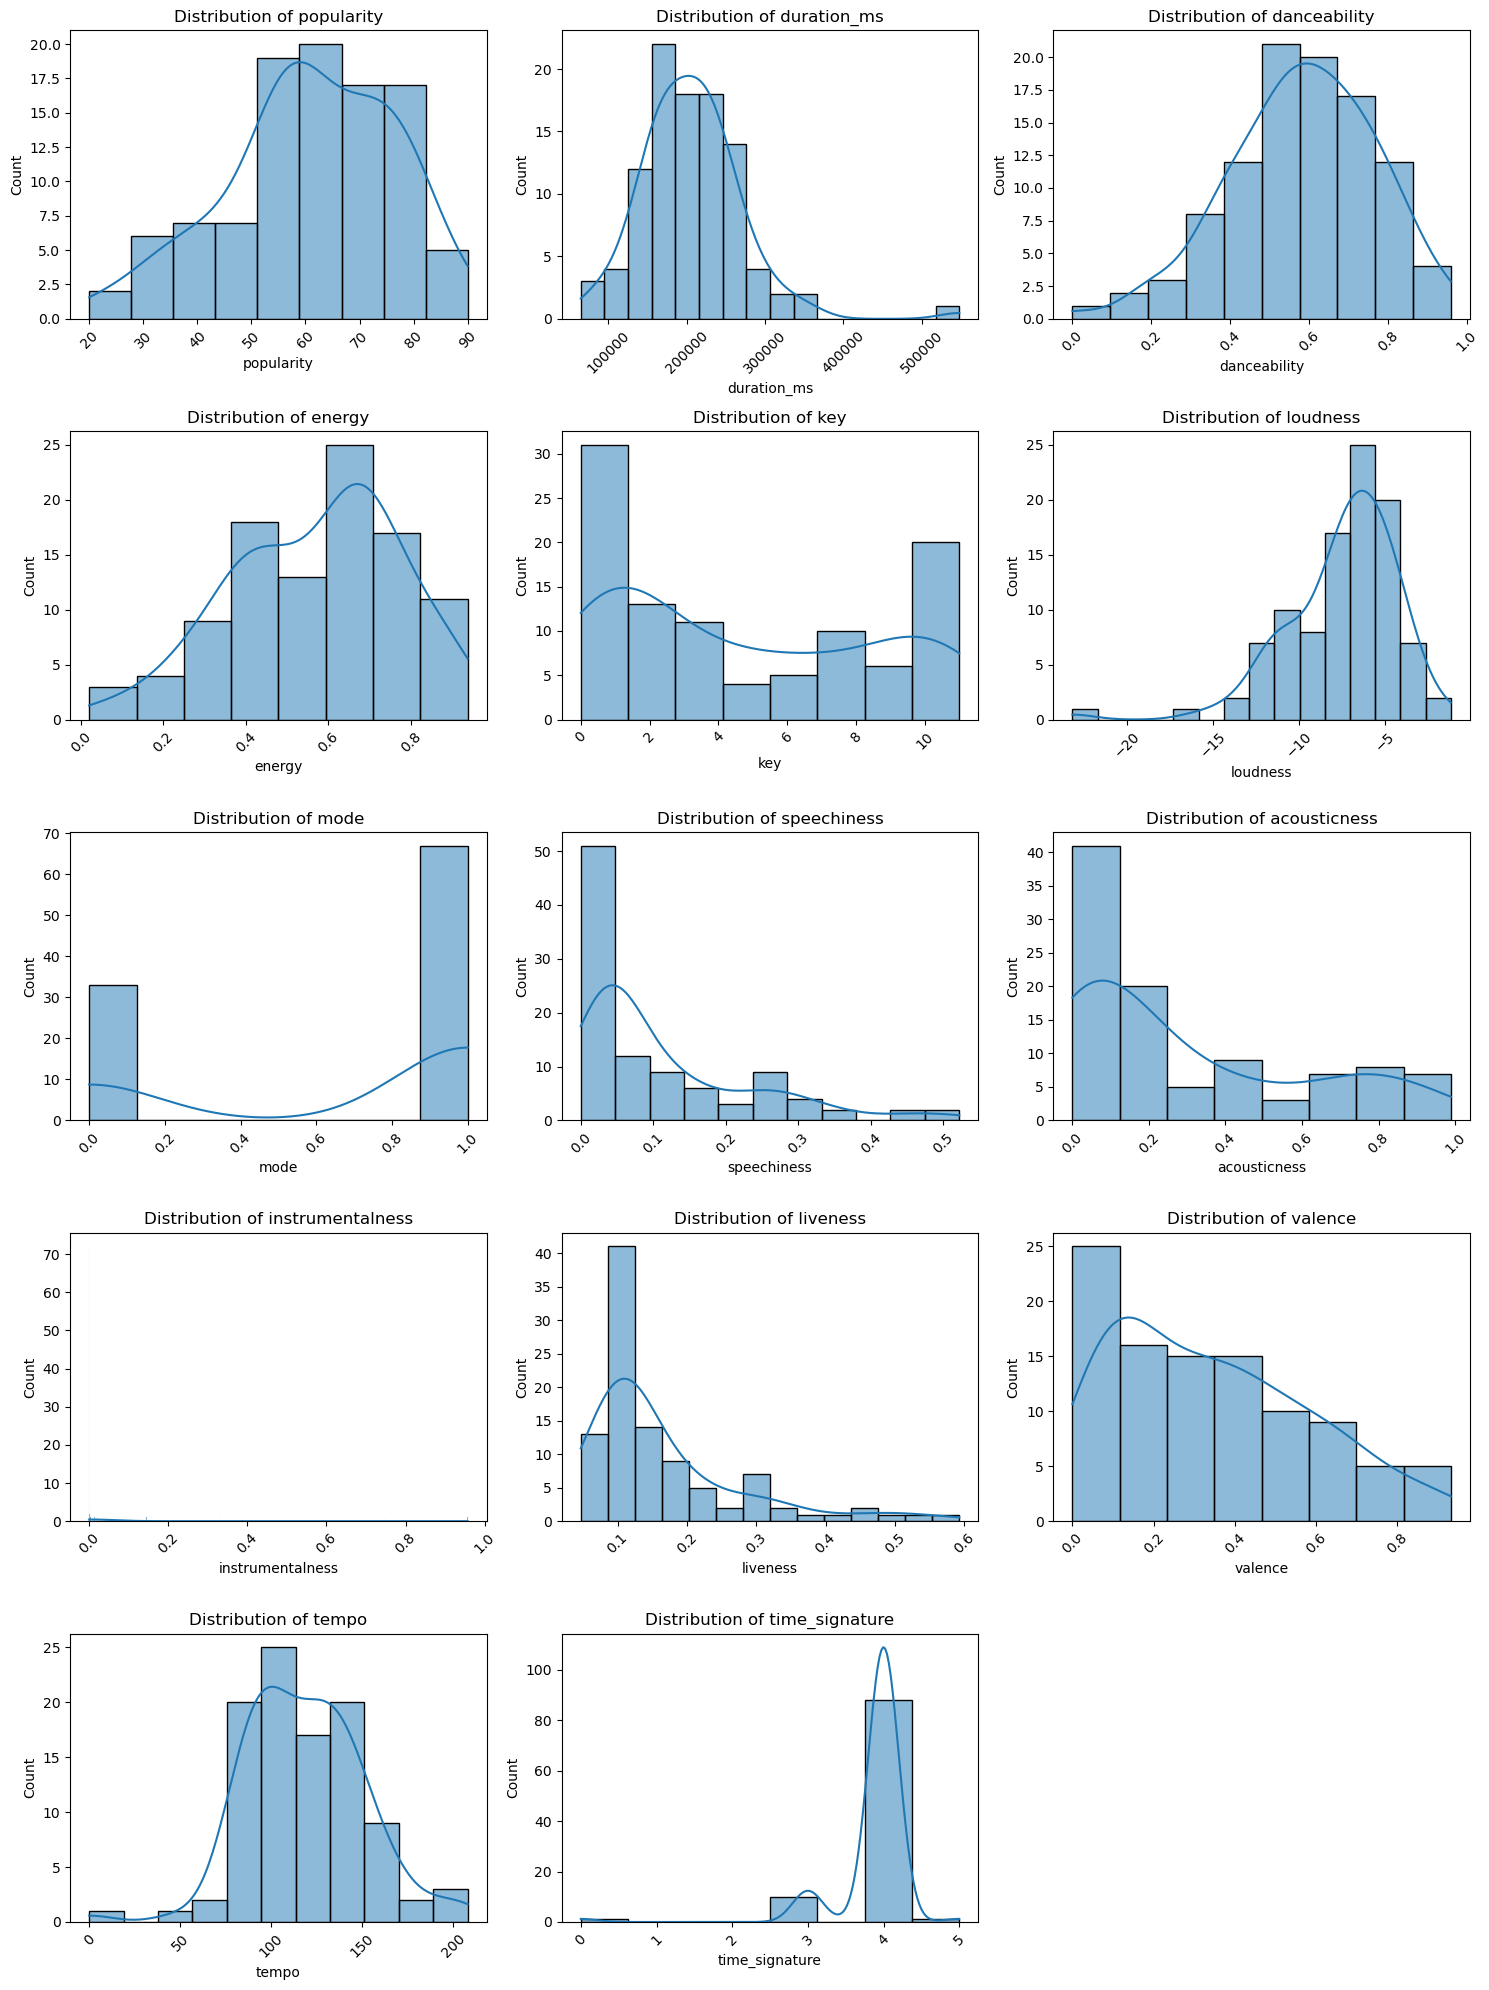

In [73]:
plot_feature_distributions(my_track_data_df, numeric_cols, cat_cols)

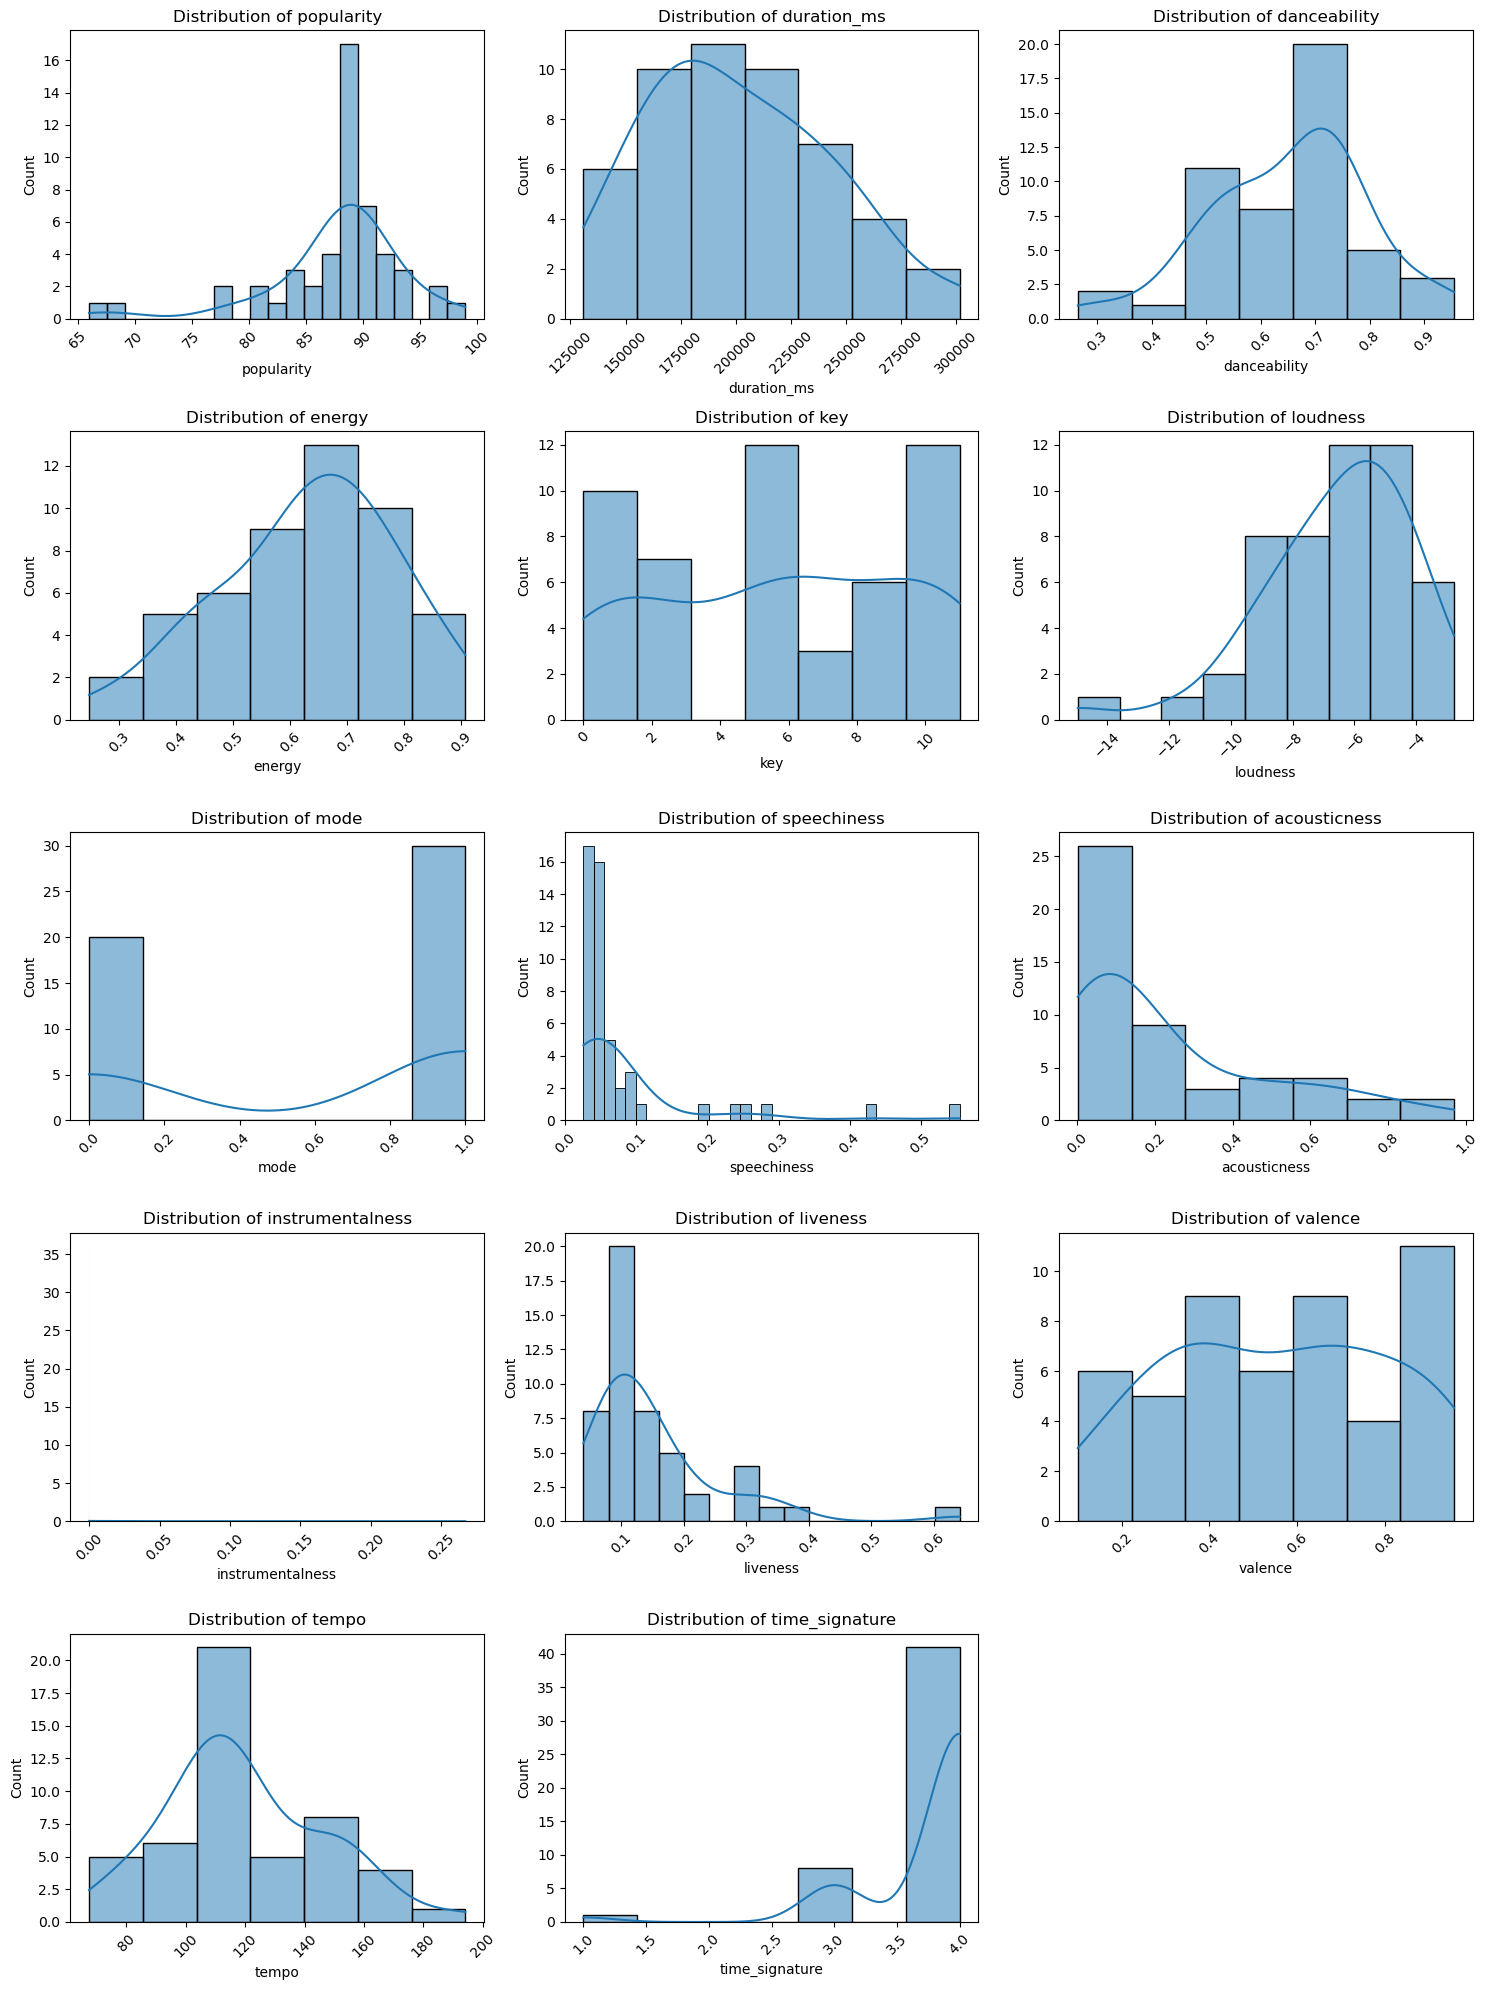

In [74]:
plot_feature_distributions(global_track_data_df, numeric_cols, cat_cols)


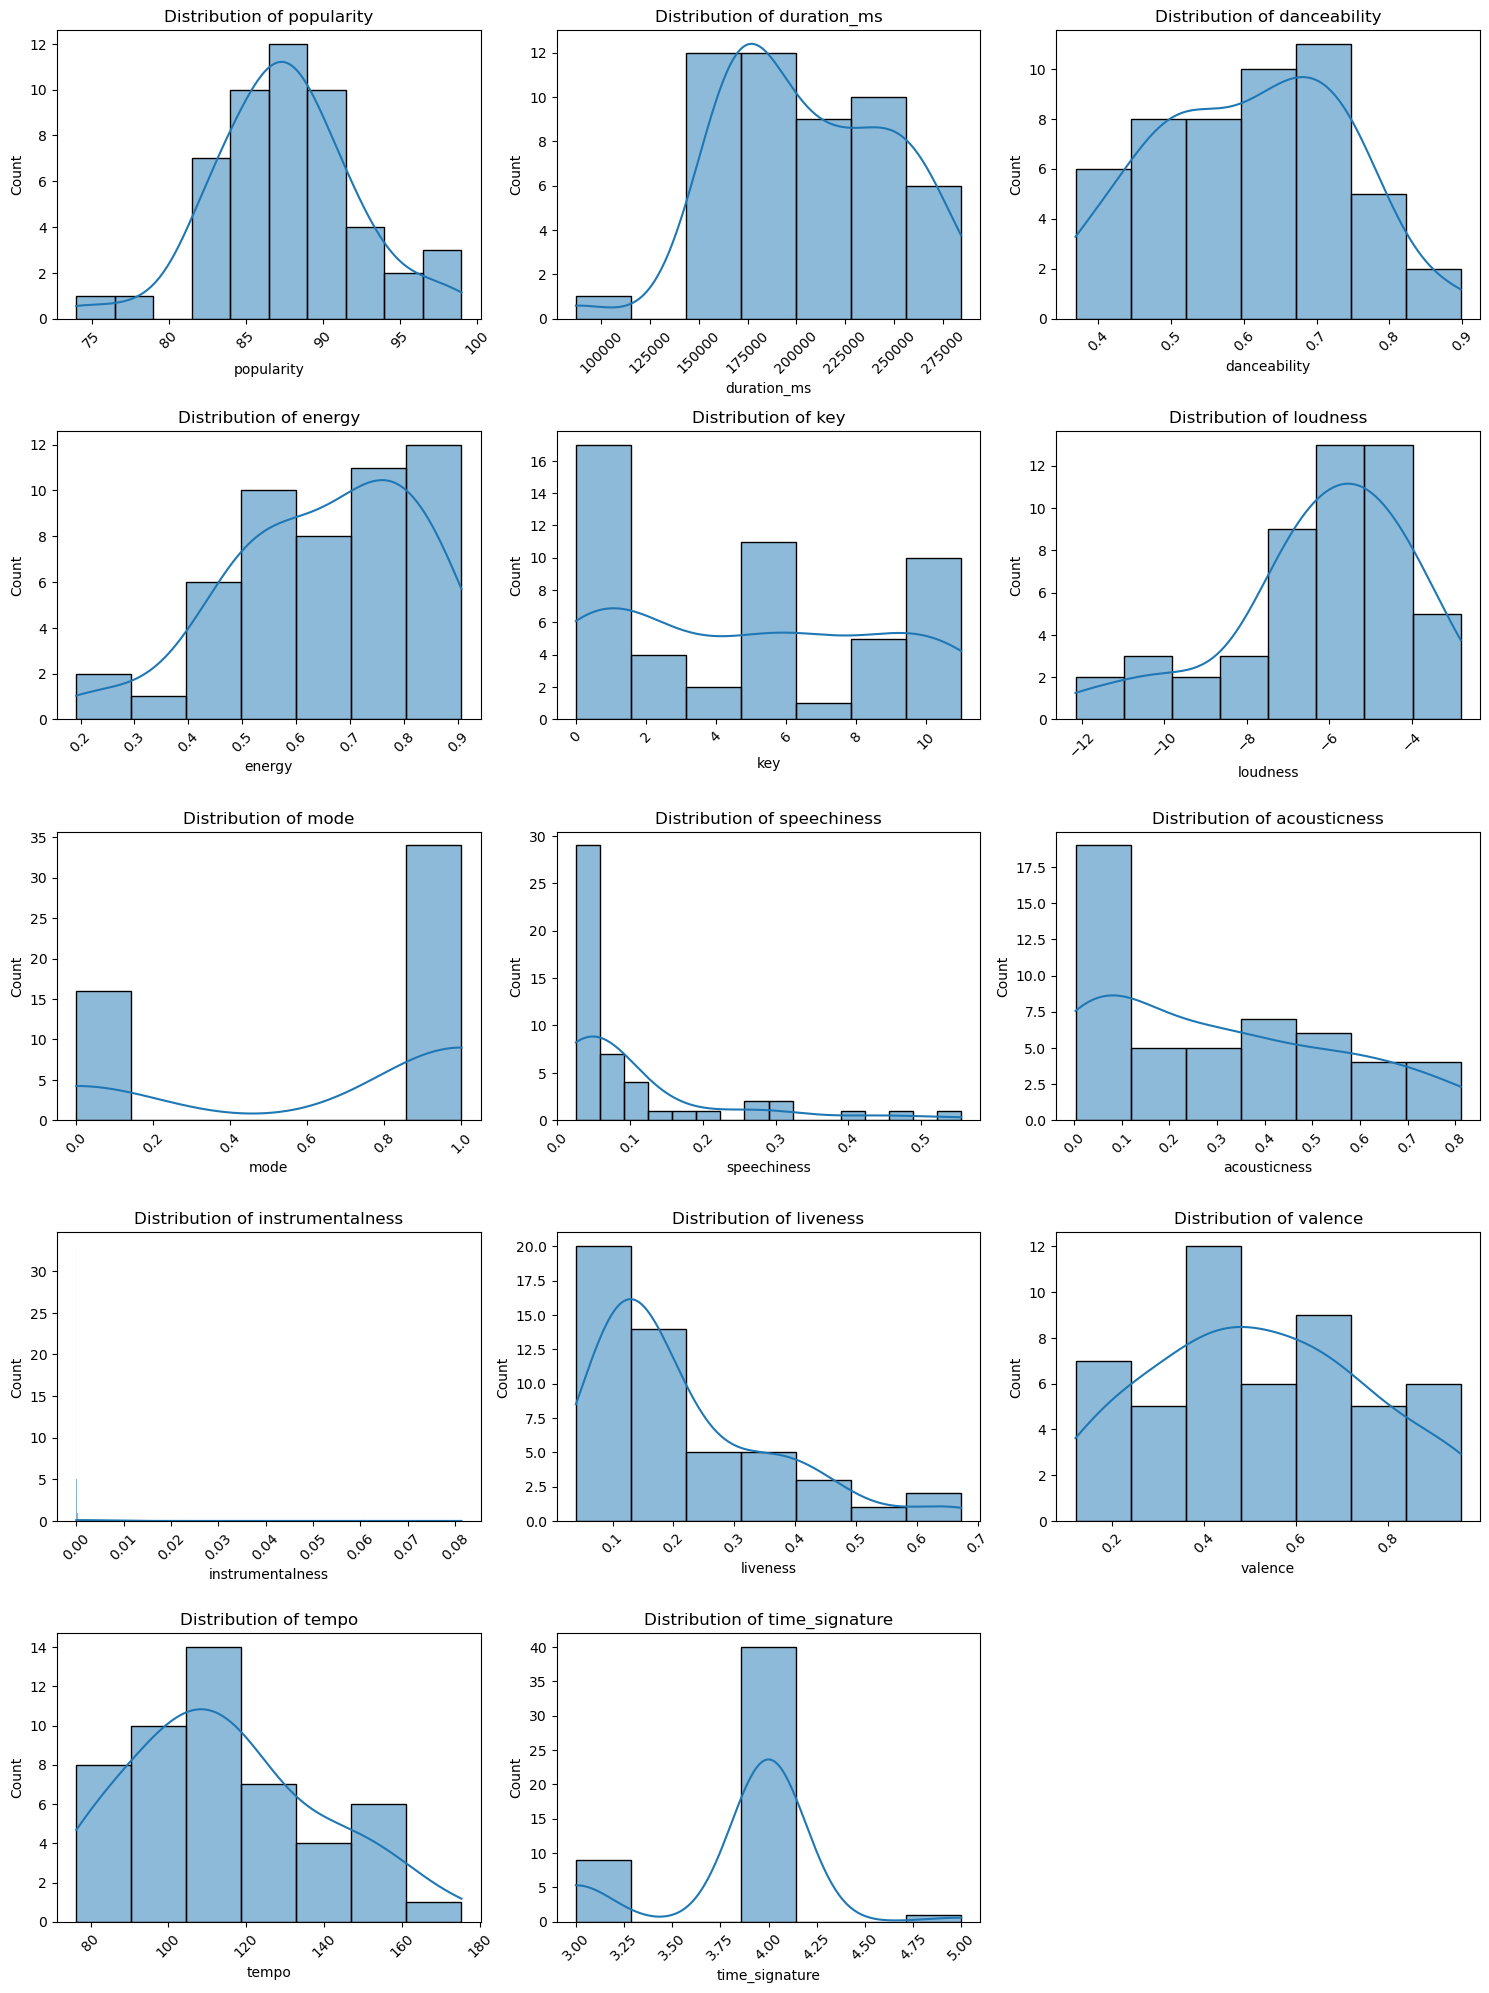

In [75]:
plot_feature_distributions(usa_track_data_df, numeric_cols, cat_cols)


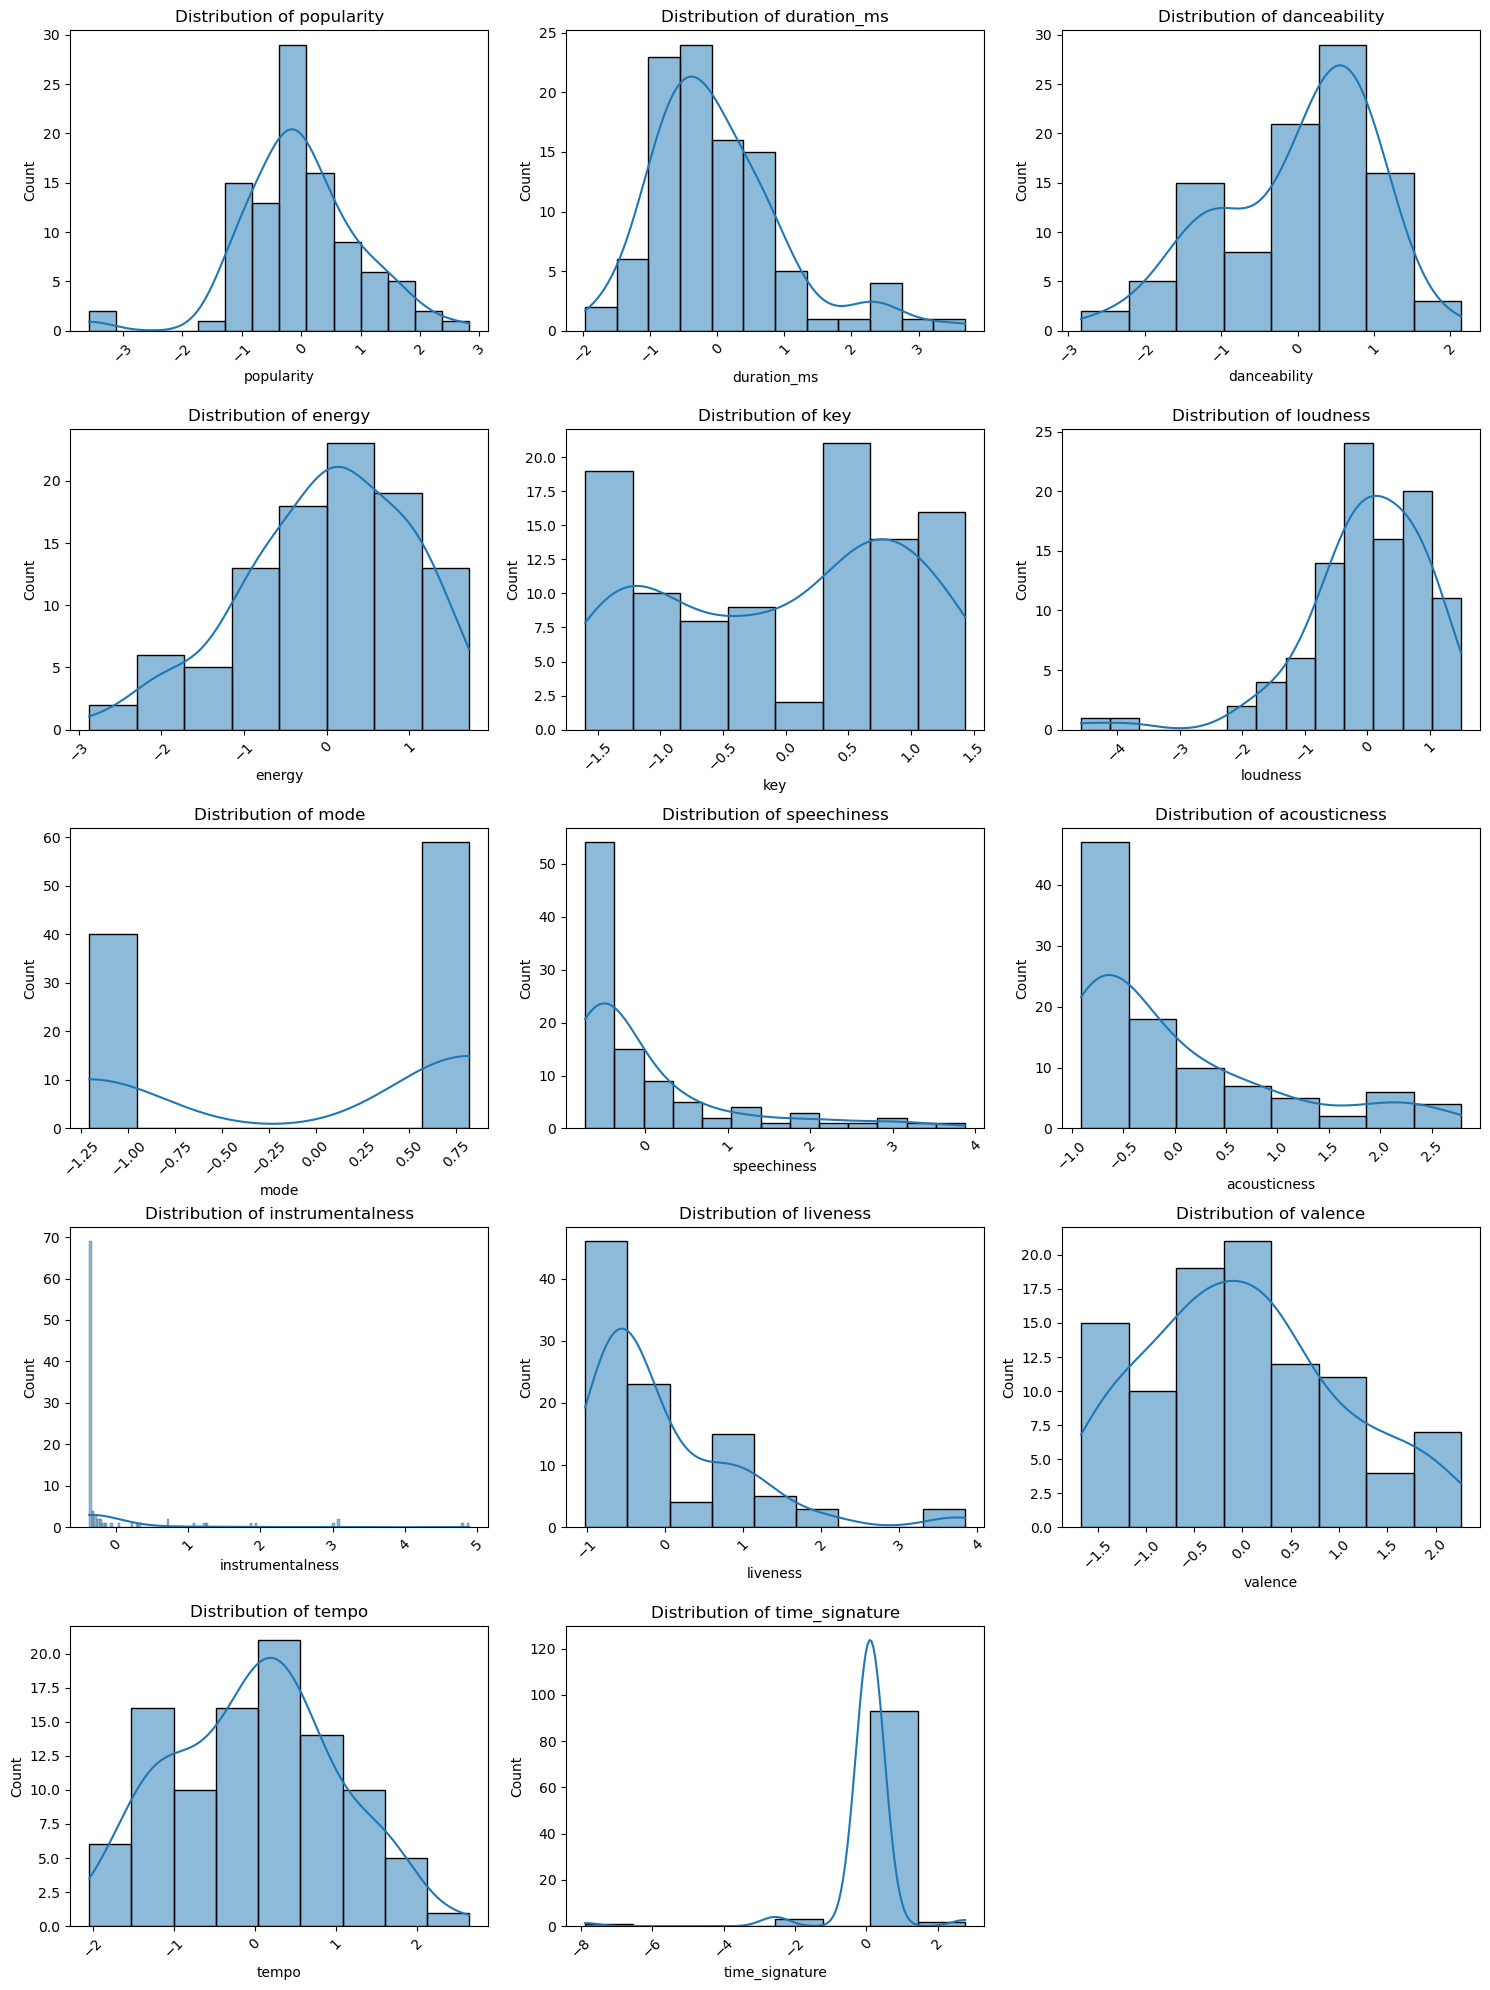

In [76]:
plot_feature_distributions(new_track_data_df, numeric_cols, cat_cols)

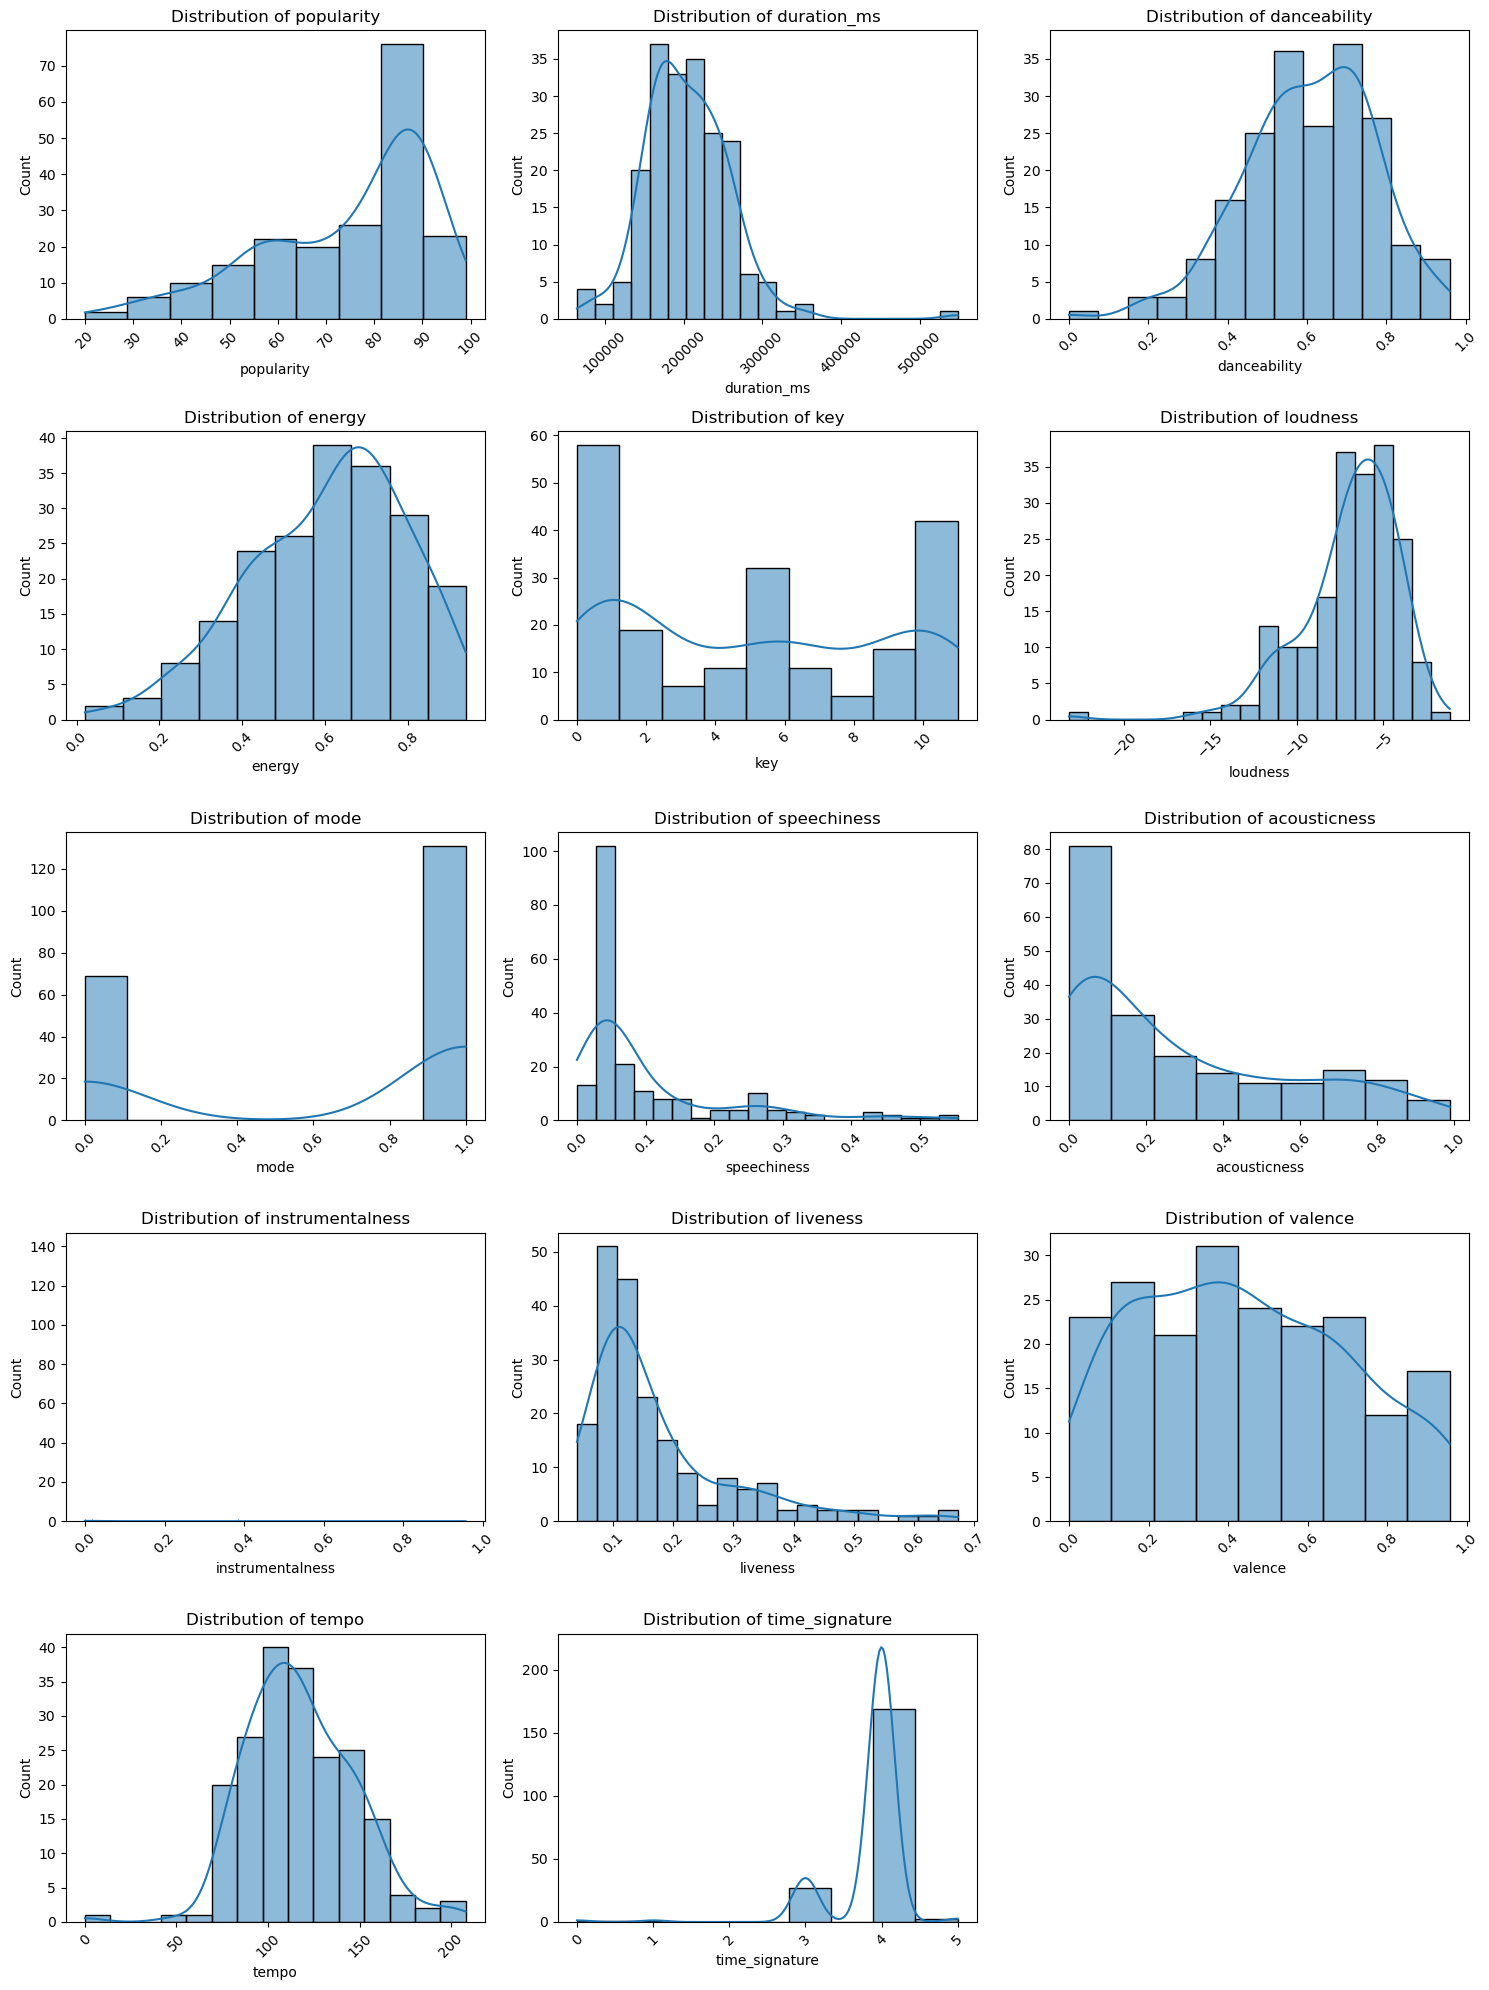

In [77]:
plot_feature_distributions(combined_df, numeric_cols, cat_cols)

In [79]:
my_track_data_df.describe()

print(my_track_data_df.describe().loc['mean'])

popularity              60.950000
duration_ms         206061.410000
danceability             0.583050
energy                   0.570603
key                      4.710000
loudness                -7.475900
mode                     0.670000
speechiness              0.114259
acousticness             0.296842
instrumentalness         0.041659
liveness                 0.165148
valence                  0.341277
tempo                  118.518870
time_signature           3.870000
Name: mean, dtype: float64


In [80]:
print(my_track_data_df['explicit'].value_counts())

explicit
False    54
True     46
Name: count, dtype: int64
